<a href="https://colab.research.google.com/github/alperengulunay/Music-Genre-Classification/blob/main/InceptionResNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import cv2
import numpy as np
import subprocess
import matplotlib.pyplot as plt
import tensorflow

In [ ]:
train_dir = r'/content/drive/My Drive/Tüm Veriler/6000 mel_spec 44100 changed pop/train'
validation_dir = r'/content/drive/My Drive/Tüm Veriler/6000 mel_spec 44100 changed pop/validation'
test_dir = r'/content/drive/My Drive/Tüm Veriler/6000 mel_spec 44100 changed pop/test'

In [ ]:
def freez(conv_base, what_percent):
  param_sum = 0
  trainable_param_count = 0
  still_count = True
  for layer in conv_base.layers:
    param_sum += layer.count_params()
    if (param_sum / conv_base.count_params() > what_percent/100):
      layer.trainable = True
      anchor = param_sum / conv_base.count_params()
      trainable_param_count = param_sum
    # elif ((abs((param_sum / conv_base.count_params())- what_percent/100) < abs(anchor - what_percent/100)) and still_count == True):
    #   layer.trainable = True
    #   still_count = False
    #   trainable_param_count = param_sum
    else:
      layer.trainable = False
  # conv_base.summary()
  print("{:02%}".format(trainable_param_count/conv_base.count_params()))

In [ ]:
def inception_resnet_v2():
  return tensorflow.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(299, 299, 3),
    pooling='avg',
    classes=10,
    classifier_activation='softmax'
    )

conv_base = inception_resnet_v2()
# conv_base.summary()

219070464/219055592 [==============================] - 2s 0us/step


In [ ]:
#functional model
inputs = tensorflow.keras.Input(shape=(299, 299, 3))

x = conv_base(inputs)
x = tensorflow.keras.layers.Dropout(.3, input_shape=(2,))(x)
x = tensorflow.keras.layers.Dense(256, activation = 'relu')(x)
x = tensorflow.keras.layers.Dropout(.3, input_shape=(2,))(x)
x = tensorflow.keras.layers.Dense(128, activation = 'relu')(x)
outputs = tensorflow.keras.layers.Dense(10, activation = 'softmax')(x)

tensorflow.random.set_seed(0)
# freez(xception, 50)

func_model = tensorflow.keras.Model(inputs = inputs, outputs = outputs)

func_model.compile(loss='categorical_crossentropy',
              optimizer="adamax", # tensorflow.keras.optimizers.RMSprop(learning_rate=1e-5) 
              metrics=['acc'])


model = func_model
# model.summary()

In [ ]:
# preprocessing_1
train_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(
      rescale=1.0/255,
      # rotation_range=40,
      # width_shift_range=0.2,
      # height_shift_range=0.2,
      # shear_range=0.2,
      # zoom_range=0.2,
      horizontal_flip=True
      )
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical'
        )

validation_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255
        )
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical'
        )

test_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255
        )
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(299, 299),
        batch_size=10,
        class_mode='categorical',
        shuffle=False
        )

train_y=train_generator.classes
test_y=test_generator.classes
val_y=validation_generator.classes


print(train_generator.class_indices)

Found 5000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
{'Halk': 0, 'Klasik': 1, 'Pop': 2, 'Rap': 3, 'Rock': 4, 'arabesk': 5, 'caz': 6, 'elektronik': 7, 'punk': 8, 'tasavvuf': 9}


In [ ]:
def prepro_direc_iter(dir_):
  tensorflow.keras.preprocessing.image.DirectoryIterator(
      dir_,
      train_datagen,
      target_size=(299, 299, 3),
      color_mode='rgb',
      classes=["Halk", "Klasik", "Pop", "Rap", "Rock", "arabesk", "caz", "elektronik", "punk", "tasavvuf"],
      class_mode='categorical',
      batch_size=32,
      shuffle=False,
      seed=None, # Random seed for data shuffling.
      data_format=None,
      subset=None,
      interpolation='nearest',
      dtype=None
  )
  print('for preprocessing')
dirs = [train_dir, test_dir, validation_dir]
for i in dirs:
  prepro_direc_iter(i)

Found 5000 images belonging to 10 classes.
for preprocessing
Found 500 images belonging to 10 classes.
for preprocessing
Found 500 images belonging to 10 classes.
for preprocessing


In [ ]:
call_back = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=8,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

import random
best_model_save = tensorflow.keras.callbacks.ModelCheckpoint(
    '/content/drive/My Drive/Tüm Veriler/best_model' + str(random.randint(0,100000)) + '.h5',
    monitor='val_acc',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
)


# Training the model.
history = model.fit(
      train_generator,
      # steps_per_epoch=62,
      epochs=20,
      steps_per_epoch = 156,
      callbacks = [call_back, best_model_save],
      validation_data = validation_generator
      )

Epoch 1/20
156/156 [==============================] - 4276s 27s/step - loss: 1.5382 - acc: 0.4573 - val_loss: 1.1408 - val_acc: 0.6560
Epoch 2/20
156/156 [==============================] - 184s 1s/step - loss: 0.7747 - acc: 0.7317 - val_loss: 1.0155 - val_acc: 0.6760
Epoch 3/20
156/156 [==============================] - 175s 1s/step - loss: 0.5496 - acc: 0.8124 - val_loss: 1.7295 - val_acc: 0.5060
Epoch 4/20
156/156 [==============================] - 175s 1s/step - loss: 0.4014 - acc: 0.8635 - val_loss: 1.6577 - val_acc: 0.5760
Epoch 5/20
156/156 [==============================] - 185s 1s/step - loss: 0.3290 - acc: 0.8881 - val_loss: 1.0728 - val_acc: 0.7360
Epoch 6/20
156/156 [==============================] - 184s 1s/step - loss: 0.2301 - acc: 0.9241 - val_loss: 0.8931 - val_acc: 0.7660
Epoch 7/20
156/156 [==============================] - 184s 1s/step - loss: 0.1664 - acc: 0.9420 - val_loss: 0.8356 - val_acc: 0.7840
Epoch 8/20
156/156 [==============================] - 175s 1s/step 

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)

50/50 [==============================] - 415s 8s/step - loss: 0.8497 - acc: 0.8200


In [ ]:
model_path = r'/content/drive/MyDrive/Tüm Veriler/8320-8480.h5'
model = tensorflow.keras.models.load_model(model_path)

In [ ]:
##
Ypred = model.predict(test_generator)

Ypred = np.argmax(Ypred, axis=1)

In [ ]:
model.evaluate(test_generator)

50/50 [==============================] - 5s 76ms/step - loss: 0.6555 - acc: 0.8480


[0.6555252075195312, 0.8479999899864197]

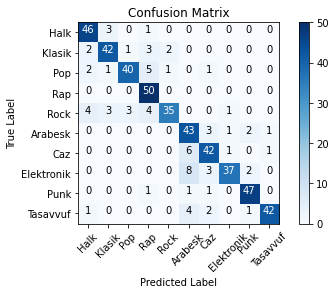

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,title='Confusion Matrix', cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
plot_confusion_matrix(confusion_matrix(test_y,Ypred), classes=['Halk','Klasik','Pop','Rap','Rock','Arabesk','Caz','Elektronik','Punk','Tasavvuf'])

In [ ]:
classification_report(test_y,Ypred)

'              precision    recall  f1-score   support\n\n           0       0.84      0.92      0.88        50\n           1       0.86      0.84      0.85        50\n           2       0.91      0.80      0.85        50\n           3       0.78      1.00      0.88        50\n           4       0.92      0.70      0.80        50\n           5       0.69      0.86      0.77        50\n           6       0.81      0.84      0.82        50\n           7       0.93      0.74      0.82        50\n           8       0.90      0.94      0.92        50\n           9       0.95      0.84      0.89        50\n\n    accuracy                           0.85       500\n   macro avg       0.86      0.85      0.85       500\nweighted avg       0.86      0.85      0.85       500\n'